**NAMA: ZAENAL ALFIAN** <br>
**NIM: 202101251002**


-------



# **Datasets dari Kaggle**

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zaenalalfian","key":"21a41f9eada9f386b765366f9d909d53"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets list

ref                                                  title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                      DAIGT V2 Train Dataset                      29MB  2023-11-16 01:38:36           3020        252  1.0              
rishabhkarn/ipl-auction-2023                         IPL Auction 2023                             4KB  2023-12-24 10:45:03            674         26  0.9411765        
bhavikjikadara/car-price-prediction-dataset          Car Price Prediction Dataset                 4KB  2023-12-23 07:07:54           1246         33  0.9411765        
muhammadbinimran/housing-price-prediction-data       Housing Price Prediction Data              763KB  2023-11-21 17:56:32          12780        218  1.0       

In [ ]:
! kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [00:25<00:00, 106MB/s] 
100% 1.96G/1.96G [00:25<00:00, 82.0MB/s]


In [ ]:
!mkdir hundred-birds
!unzip 100-bird-species.zip -d hundred-birds
!ls hundred-birds

Streaming output truncated to the last 5000 lines.
  inflating: hundred-birds/train/WHITE TAILED TROPIC/121.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/122.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/123.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/124.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/125.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/126.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/127.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/128.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/129.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/130.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/131.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/132.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/133.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/134.jpg  
  inflating: hundred-birds/train/WHITE TAILED TROPIC/135.jpg  
  in

# **Import library dan modules yang diperlukan**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from PIL import Image

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from sklearn.metrics import accuracy_score

In [ ]:
data_dir = "hundred-birds"

IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32

In [ ]:
# checking a random image
sample_image = Image.open("hundred-birds/test/ALPINE CHOUGH/4.jpg")
print("Shape of the sample image: ", sample_image.size)
print("Image Mode: ", sample_image.mode)

Shape of the sample image:  (224, 224)
Image Mode:  RGB


# **Cek file gambar dan kelas datasets**

In [ ]:
## Load the data using tf
def load_data(data_dir):

    train_images = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, 'train'),
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE
    )

    dev_images = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, 'test'),
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE
    )

    test_images = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, 'valid'),
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE
    )

    return train_images, dev_images, test_images

train_dataset, dev_dataset, test_dataset = load_data(data_dir)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


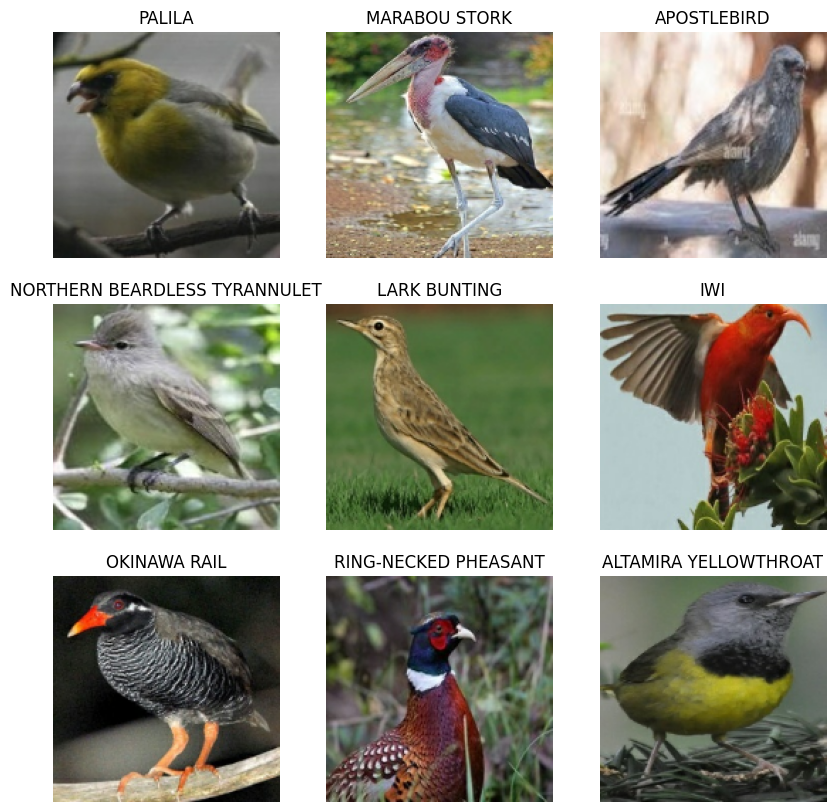

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## **Preprocess dan Augmentasi Data**

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

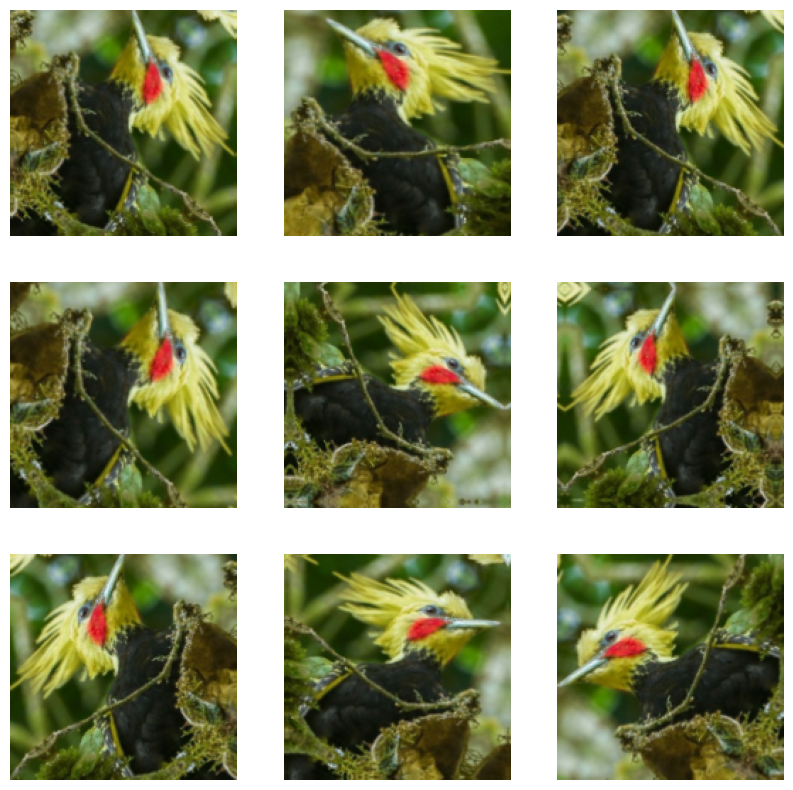

In [ ]:
def data_augmenter():

    data_augmentation = tf.keras.models.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.1))

    return data_augmentation

data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # preprocess transfer learning mobilenetv2

# **MobileNet V2 sebagai Basemodel**

In [ ]:
IMG_SHAPE = IMAGE_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
def make_model(image_shape, data_augmetation, base_model):

    input_shape = image_shape + (3,)

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmetation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tfl.GlobalMaxPooling2D()(x)
    output = tfl.Dense(525)(x)

    model = tf.keras.Model(inputs, output)

    return model

In [ ]:
model = make_model(IMAGE_SIZE, data_augmenter(), base_model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*0.001)
metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
# Unfreezing the last few layers
base_model.trainable = True

total_layers = len(base_model.layers)
print("Total Layers In Base Model: ", total_layers)

fine_tune_at = 120

# unfreeze rest of the layers
for layers in base_model.layers[:fine_tune_at]:
    layers.trainable=False

model.summary()

Total Layers In Base Model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                            

# **Tahap Training Model**

In [ ]:
%%time
history = model.fit(train_dataset,
                    validation_data=dev_dataset,
                    epochs=10)

Epoch 1/10
2645/2645 [==============================] - 2112s 798ms/step - loss: 1.3258 - accuracy: 0.6727 - val_loss: 0.7100 - val_accuracy: 0.8004
Epoch 2/10
2645/2645 [==============================] - 2076s 785ms/step - loss: 1.1811 - accuracy: 0.7044 - val_loss: 0.6314 - val_accuracy: 0.8141
Epoch 3/10
2645/2645 [==============================] - 2033s 769ms/step - loss: 1.0787 - accuracy: 0.7277 - val_loss: 0.5859 - val_accuracy: 0.8347
Epoch 4/10
2645/2645 [==============================] - 2076s 785ms/step - loss: 0.9933 - accuracy: 0.7455 - val_loss: 0.5554 - val_accuracy: 0.8400
Epoch 5/10
2645/2645 [==============================] - 2049s 775ms/step - loss: 0.9301 - accuracy: 0.7601 - val_loss: 0.5183 - val_accuracy: 0.8450
Epoch 6/10
2645/2645 [==============================] - 2003s 757ms/step - loss: 0.8790 - accuracy: 0.7718 - val_loss: 0.5101 - val_accuracy: 0.8442
Epoch 7/10
2645/2645 [==============================] - 2022s 764ms/step - loss: 0.8365 - accuracy: 0.7811

# **Menampilkan performa akurasi model**

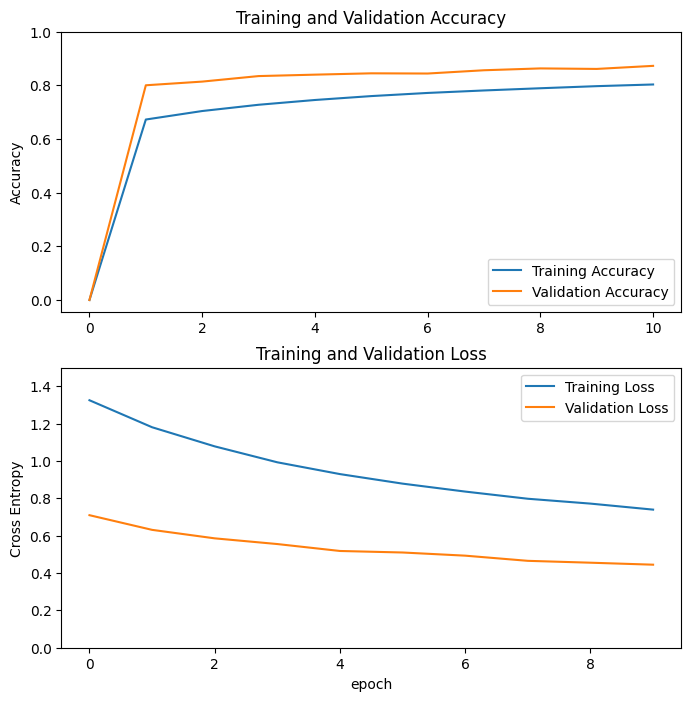

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Tes pada test datasets
pred = model.predict(test_dataset)

83/83 [==============================] - 64s 714ms/step


In [ ]:
labels_array = np.array([])
pred_array = np.array([])

for x, y in test_dataset.take(1):
    pred_prob = model.predict(x)
    labels_array = np.concatenate([labels_array, y])
    pred_class = np.argmax(pred_prob, axis=1)
    pred_array = np.concatenate([pred_array, pred_class])

1/1 [==============================] - 2s 2s/step


# **Mengecek tingkat akurasi pada tes**

In [ ]:
print("Accuracy On Test Dataset: ", accuracy_score(labels_array, pred_array))

Accuracy On Test Dataset:  0.875


# **Deploy model TFLite**

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('uas.tflite')
tflite_model_file.write_bytes(tflite_model)

11555236